# Introduction to Digital Signal Processing

Originally written by I. Guinn, updated by S. L. Watkins

This notebook will provide a brief introduction to a few of LEGEND's bread and butter digital signal processing filters. These processors will be applied in sequence to digitized waveforms that are recorded to disk, and a brief explanation of why we use them is provided. The parameters of each processor may be varied as well in order to see the affects that they have.

Recommended reading is *Radiation Detection and Measurement* by Glenn F. Knoll, Chapter 17, which introduces many pulse-shaping concepts (although, from a hardware-perspective more than a digital signal processing perspective; even so, the concepts are similar).

### Set up the python environment
It is recommended that you use a file from the LEGEND test-data repository: https://github.com/legend-exp/legend-testdata; you may need to change data_file if you want to run this notebook yourself. We use the Python wrapper of the test-data repository: https://github.com/legend-exp/legend-testdata-py

In [1]:
from pygama.lgdo import LH5Store
from pygama.vis import WaveformBrowser
from pygama.math import units
import matplotlib.pyplot as plt
import os
from legend_testdata import LegendTestData

ldata = LegendTestData()
data_file = ldata.get_path("lh5/LDQTA_r117_20200110T105115Z_cal_geds_raw.lh5")
entry_no = 2 # which waveform in our example data_file to use

from matplotlib import rc

rc('axes', labelsize=10)
rc('font', size=10)
rc('legend', fontsize=10)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)

### Processor Setup
This next panel defines all of the processors that we are going to run. Normally this is done in a JSON file in almost the exact same format shown here. You are encouraged to try changing some of the values in these processors to see the effect on the analysis

In [2]:
dsp_config = {
    "processors": {
        "max_index": {
            "function": "argmax",
            "module": "numpy",
            "args": ["waveform", 1, "max_index"],
            "kwargs": {"signature": "(n),()->()", "types": ["fi->i"]},
            "unit": "ADC",
            "prereqs":[ "waveform"],
        },

        "bl, bl_sig, slope, intercept": {
            "function": "linear_slope_fit",
            "module": "pygama.dsp.processors",
            "args" : ["waveform[:1650]", "bl", "bl_sig", "slope", "intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"],
        },

        "wf_blsub": {
            "function": "subtract",
            "module": "numpy",
            "args": ["waveform", "bl", "wf_blsub"],
            "unit": "ADC",
        },

        "wf_pz": {
            "function": "pole_zero",
            "module": "pygama.dsp.processors",
            "args": ["wf_blsub", "180*us", "wf_pz"],
            "unit": "ADC",
        },

        "wf_trap": {
            "function": "trap_norm",
            "module": "pygama.dsp.processors",
            "args": ["wf_pz", "8*us", "2*us", "wf_trap"],
            "unit": "ADC",
        },

        "trapEmax": {
            "function": "amax",
            "module": "numpy",
            "args": ["wf_trap", 1, "trapEmax"],
            "kwargs": {"signature": "(n),()->()", "types": ["fi->f"]},
            "unit": "ADC",
        },

        "trapTmax": {
            "function": "argmax",
            "module": "numpy",
            "args": ["wf_trap", 1, "trapTmax"],
            "kwargs": {"signature": "(n),()->()", "types": ["fi->i"]},
            "unit": "ns",
        },

        "wf_atrap": {
            "function": "asym_trap_filter",
            "module": "pygama.dsp.processors",
            "args": ["wf_pz", "0.1*us", "1*us", "3*us", "wf_atrap"], # rising edge, flat section, falling edge
            "unit": "ADC",
        },

        "tmax": {
            "function": "argmax",
            "module": "numpy",
            "args": ["wf_atrap", 1, "tmax"],
            "kwargs": {"signature": "(n),()->()", "types": ["fi->i"]},
            "unit": "ns",
        },

        "tp_0": {
            "function": "time_point_thresh",
            "module": "pygama.dsp.processors",
            "args": ["wf_atrap", 0, "tmax", 0, "tp_0"],
            "unit": "ns",
        },

        "ftp": {
            "function": "add",
            "module": "numpy",
            "args": ["tp_0", "2*us+8*us-256*ns", "ftp"],
            "unit": "ns",
        },

        "trapEftp": {
            "function": "fixed_time_pickoff",
            "module": "pygama.dsp.processors",
            "args": ["wf_trap", "ftp", "105", "trapEftp"], # ord('i') == 105
            "unit": "ADC",
        },

        "curr": {
            "function": "avg_current",
            "module": "pygama.dsp.processors",
            "args": ["wf_pz", 1, "curr(len(wf_pz)-1, 'f', period=waveform.period)"],
            "unit": "ADC/sample",
        },

        "curr_gaus": {
            "function": "gaussian_filter1d",
            "module": "pygama.dsp.processors",
            "args": ["curr", "curr_gaus(len(curr), 'f', period=waveform.period)"],
            "init_args": ["50", '4'],
            "unit": "ADC/sample",
        },

        "A_gaus": {
            "function": "amax",
            "module": "numpy",
            "args": ["curr_gaus", 1, "A_gaus"],
            "kwargs": {"signature": "(n),()->()", "types": ["fi->f"]},
            "unit": "ADC/sample",
        },
    },
}

### Plotting Processors via `WaveformBrowser`

#### Raw Waveform
This is a waveform as produced by a flashcam digitizer. The waveform can be divided into three regions; first, the baseline, the flat part up to ~45000 ns. Next the rising edge, where it increases at ~45000 ns. Lastly, the falling tail, which is an approximately exponential return to baseline that begins after ~45000 ns

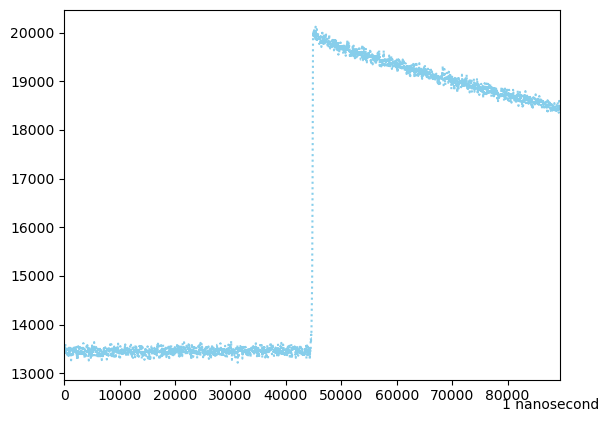

In [3]:
# note, we do not specify the lines kwarg, in which case the raw waveform is plotted
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    styles=[
        {'color':['skyblue'], "ls":['dotted']},
    ]
)
browser.draw_entry(entry_no)

#### Baseline Subtraction
The first processors applied perform baseline subtraction. First we measure the baseline using the first 1650 samples of the waveform, and then we subtract the baseline from each sample.

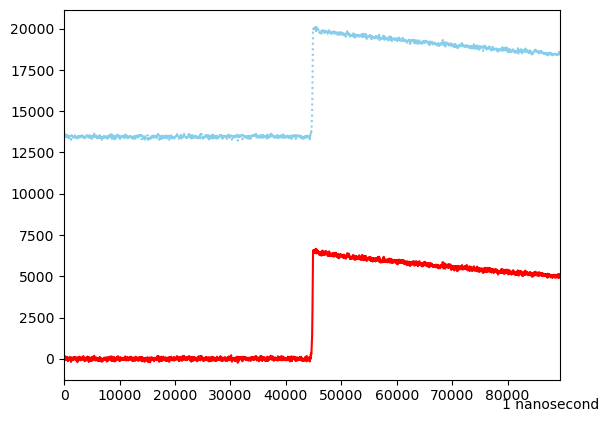

In [4]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=["waveform", "wf_blsub"],
    styles=[
        {'color': ['skyblue'], "ls": ['dotted']},
        {'color': ['r']},
    ],
)
browser.draw_entry(entry_no)

#### Pole-Zero Correction
The next step is to correct our waveform for the electronics response, which produces the exponential shape characteristic of our waveforms. The goal of this transform is to return a waveform with a perfectly flat tail. The pole-zero correction assumes a simple electronics response characterized by a single RC constant (in this case 180 us). In reality, our electronics can be characterized by multiple RC constants; as a result we do not achieve a perfectly flat top, but by applying more complex transforms at this step we can improve things. The pole-zero applied here is close enough for most applications, though.

Knoll chapter 17 sec 7B has a more complete description.

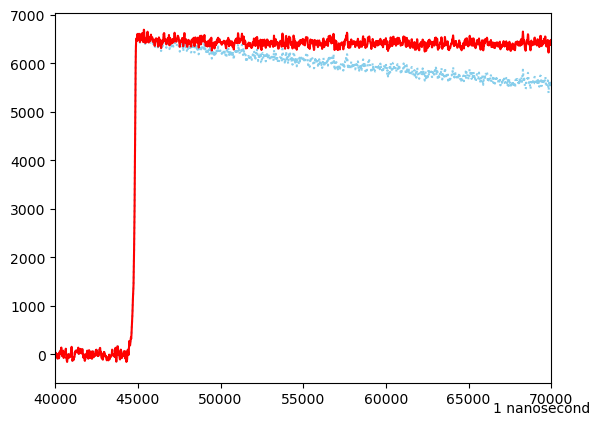

In [5]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=["wf_blsub", "wf_pz"],
    styles=[
        {'color': ['skyblue'], "ls": [':']},
        {'color': ['r']},
    ],
    x_lim=(40000, 70000),
)
browser.draw_entry(entry_no)

#### Trapezoidal Filter
The trapezoidal filter is a nearly optimal filter that is used to extract pulse amplitude for a variety of applications. The trapezoid is the difference, at each point, between the average over two sets of samples separated by a short time. It can be characterized by:
- Integration time: number of samples averaged, and the length of the rising and falling edges of the trapezoid. We use 8 us here. A longer integration time will reduce the effect of noise on our energy measurement (up to a limit that depends on low frequency noise; it also can't be too long for the number of samples collected).
- Flat top time: the separation between the integration regions, and the length of the flat top of the trapezoid. This should be longer than the rising edge of the waveform; if it is not, the top will not be totally flat and we will measure a reduction in the charge called "ballistic deficit." We also don't want the flat top to be too long, or else low frequency noise will degrade our resolution. Here, we use 2 us as our flat top time.

Knoll Chapter 17 Section 7 has a description of trapezoidal shaping.

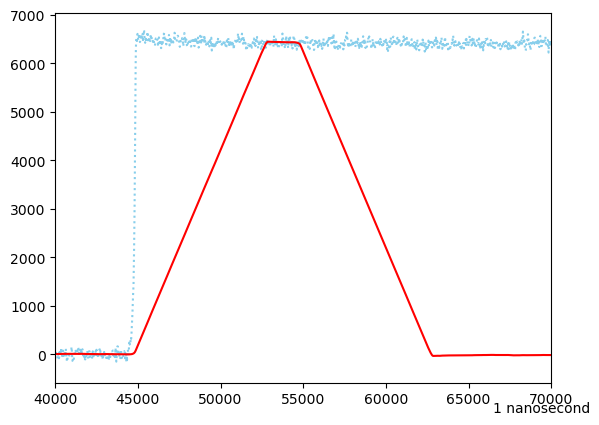

In [6]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=["wf_pz", "wf_trap"],
    styles=[
        {'color': ['skyblue'], "ls": [':']},
        {'color': ['r']},
    ],
    x_lim=(40000, 70000),
)
browser.draw_entry(entry_no)

#### Energy estimation: trap-max
The most common way to measure uncalibrated energy is to use the maximum of the trapezoidal filter. This works fairly well, assuming you have a nice flat top; however, due to our imperfect pole-zero correction, this can result in a degradation in our energy resolution

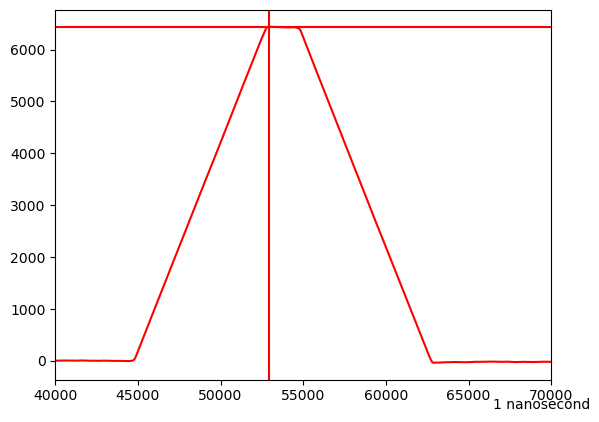

In [7]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=["wf_trap", "trapEmax", "trapTmax"],
    styles={'color': ['r']},
    x_lim=(40000, 70000),
)
browser.draw_entry(entry_no)

#### Energy estimation: fixed time pick-off
Another way to measure energy is to pick-off the amplitude of the trapezoidal filter at a fixed time relative to the start of the waveform. The fixed time should fall on the flat top of the waveform, with enough padding to avoid ballistic deficit, and to prevent noise in the start time from pushing the pick-off time onto the falling edge of the waveform. We choose a pickoff time 0.25 us before the falling edge begins. This technique also requires an accurate measurement of the start time (t0) of the waveform (see next panel...)

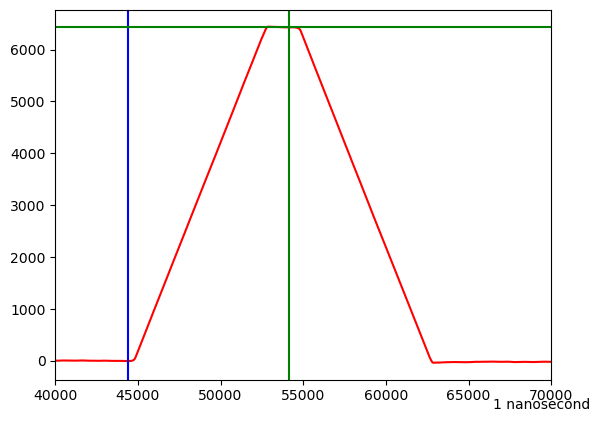

In [8]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=["wf_trap", "tp_0", "ftp", "trapEftp"],
    styles=[
        {'color': ['r']},
        {'color': ['b']},
        {'color': ['g']},
        {'color': ['g']},
    ],
    x_lim=(40000, 70000),
)
browser.draw_entry(entry_no)

#### Start time measurement
The start time (t0) of the waveform must be measured in order to apply the fixed-time pickoff. We use the following technique to measure this:

1) Apply an asymmetric trapezoidal filter, which uses a short integration time for the rising edge and a long integration time for the falling tail. The short rising edge has the advantage of preserving most timing information in the rising edge. The longer tail helps us correct for low frequency noise. Here, we use 0.1-1-3] us as the rise-flat-fall times.

2) Find the maximum of the asymmetric-trap, and walk back from there until we cross zero. The first sample that we cross this threshold is our t0.

An accurate t0 is important both for the fixed-time pickoff, and for various drift-time corrections (such as for charge-trapping) that are not described in this notebook. While this filter is mostly reliable, it can occasionally fail for low signal-to-noise waveforms, or waveforms with large transiant blips in the noise.

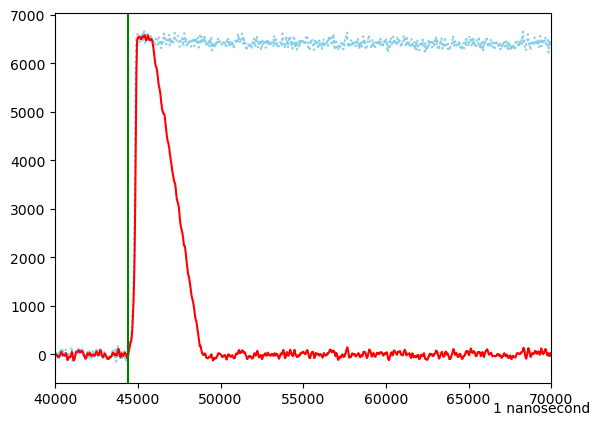

In [9]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=["wf_pz", "wf_atrap", "tp_0"],
    styles=[
        {'color': ['skyblue'], "ls": [':']},
        {'color': ['r']},
        {'color': ['g']},
    ],
    x_lim=(40000, 70000),
)
browser.draw_entry(entry_no)

#### Current measurement
Current is needed to measure A/E. This can be found using a simple derivative filter. However, the signal-to-noise using just the derivative can be quite high, so we often apply additional smoothing filters after (next panel...)

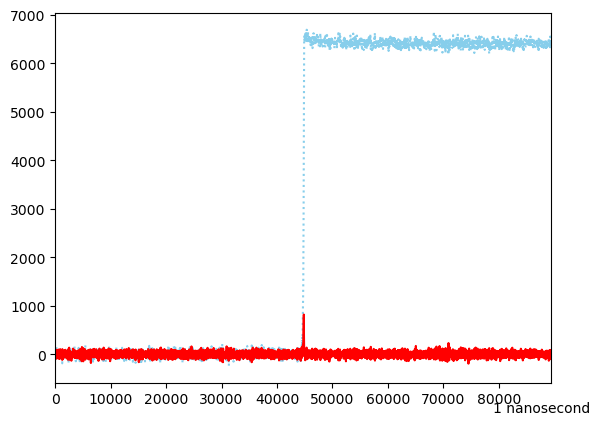

In [10]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=[
        "wf_pz",
        "curr",
    ],
    styles=[
        {'color': ['skyblue'], "ls": [':']},
        {'color': ['r']},
    ],
)
browser.draw_entry(entry_no)

#### Gaussian-smoothed current
One way we can improve the signal-to-noise ratio is by applying a gaussian filter. This is a convolution of our waveform with a gaussian kernel. While this reduces the impact of noise on our measurement, it also reduces the timing information in the rising edge, reducing the signal; as a result, we must find an optimal balance in our smoothing. Knoll chapter 17 section 4 describes gaussian shaping.

The current amplitude (A) is the maximum of the smoothed current waveform.

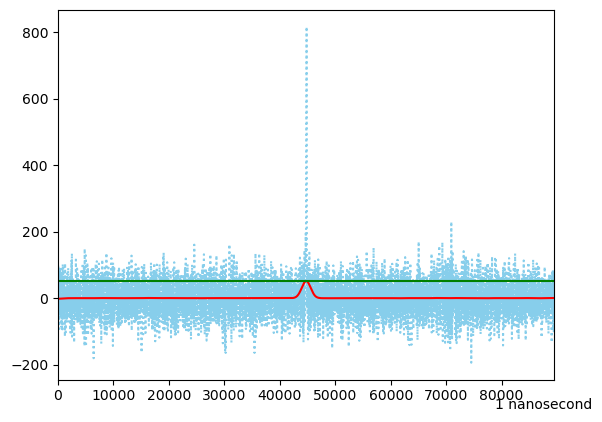

In [11]:
browser = WaveformBrowser(
    data_file,
    "geds/raw",
    dsp_config=dsp_config,
    lines=["curr", "curr_gaus", "A_gaus"],
    styles=[
        {'color': ['skyblue'], "ls": [':']},
        {'color': ['r']},
        {'color': ['g']}
    ],
)
browser.draw_entry(entry_no)

### Conclusion
This notebook has hopefully provided an informative introduction to some of the signal processing filters used by LEGEND to perform our analysis. The filters shown often have tradeoffs between reducing the impact of noise and preserving the information in the original waveform; for this reason, we typically optimize the input parameters of each processor. In addition, the parameters measured here require calibration to be physically meaningful.

